# <span style="background:rgba(10, 73, 136, 0.66); border-radius: 15px; padding: 2px 15px; text_shadow: 2px 2px 5px black"> **House sales prediction at Ames, Iowa**
</span>

The goal of this project is to predict the house sales according to seventy nine (79) features given in a dataset

In [2]:
import pandas as pd # for data manipulation & cleaning
import numpy as np # statistics and type handling
from colorama import Fore, Style # colorize output

## <span style="background:rgba(136, 134, 10, 0.49); border-radius: 15px; padding: 2px 15px; text_shadow: 2px 2px 5px black"> I. **Let's peek at the dataset**
</span>

In [3]:
data = pd.read_csv("../data/train.csv")
data.head().style.highlight_null(color="red")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,nan,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,nan,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000


In [4]:
data.describe().style.highlight_max(
                    color="green"
                    ).highlight_min(
                    color="black"
                    )

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## <span style="background:rgba(136, 134, 10, 0.49); border-radius: 15px; padding: 2px 15px; text_shadow: 2px 2px 5px black"> II. **Feature engineering + data cleaning**</span>

In [6]:
# relevant features we will use to train our model
keyFactors = [
        'Id',
        'OverallQual',
        'OverallCond',
        'YearBuilt',
        'YearRemodAdd',
        'GrLivArea', 
        'TotalBsmtSF',
        'LotArea',
        'GarageArea',
        'GarageCars',
        'GarageYrBlt',
        'GarageType',
        'GarageFinish',
        'FullBath', 
        'HalfBath',         
        'BedroomAbvGr',    
        'KitchenAbvGr',    
        'KitchenQual',      
        'ExterQual',        
        'ExterCond',        
        'BsmtCond',         
        'HeatingQC',        
        'Neighborhood',     
        'MSZoning',         
        'Fireplaces',       
        'FireplaceQu',      
        'WoodDeckSF',       
        'OpenPorchSF',      
        'Foundation',       
        'CentralAir',       
        'SaleType',
        'SaleCondition',
        'MiscFeature',        
        # target 
        'SalePrice'

]

In [7]:
df = data.copy()[keyFactors]
df.set_index("Id", inplace=True)
df.head().style.highlight_null(color="red").format(na_rep="⚠️missing")

,OverallQual,OverallCond,YearBuilt,YearRemodAdd,GrLivArea,TotalBsmtSF,LotArea,GarageArea,GarageCars,GarageYrBlt,GarageType,GarageFinish,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,ExterQual,ExterCond,BsmtCond,HeatingQC,Neighborhood,MSZoning,Fireplaces,FireplaceQu,WoodDeckSF,OpenPorchSF,Foundation,CentralAir,SaleType,SaleCondition,MiscFeature,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,7,5,2003,2003,1710,856,8450,548,2,2003.000000,Attchd,RFn,2,1,3,1,Gd,Gd,TA,TA,Ex,CollgCr,RL,0,⚠️missing,0,61,PConc,Y,WD,Normal,⚠️missing,208500
2,6,8,1976,1976,1262,1262,9600,460,2,1976.000000,Attchd,RFn,2,0,3,1,TA,TA,TA,TA,Ex,Veenker,RL,1,TA,298,0,CBlock,Y,WD,Normal,⚠️missing,181500
3,7,5,2001,2002,1786,920,11250,608,2,2001.000000,Attchd,RFn,2,1,3,1,Gd,Gd,TA,TA,Ex,CollgCr,RL,1,TA,0,42,PConc,Y,WD,Normal,⚠️missing,223500
4,7,5,1915,1970,1717,756,9550,642,3,1998.000000,Detchd,Unf,1,0,3,1,Gd,TA,TA,Gd,Gd,Crawfor,RL,1,Gd,0,35,BrkTil,Y,WD,Abnorml,⚠️missing,140000
5,8,5,2000,2000,2198,1145,14260,836,3,2000.000000,Attchd,RFn,2,1,4,1,Gd,Gd,TA,TA,Ex,NoRidge,RL,1,TA,192,84,PConc,Y,WD,Normal,⚠️missing,250000


#### **a. Let's add some features !**
we have some redundants `features` storing the same values and sharing the same information. Those columns can be merged by selected the second column.

In [8]:
data[['Exterior1st', 'Exterior2nd', 'Condition1', 'Condition2']]

,Exterior1st,Exterior2nd,Condition1,Condition2
0,VinylSd,VinylSd,Norm,Norm
1,MetalSd,MetalSd,Feedr,Norm
2,VinylSd,VinylSd,Norm,Norm
3,Wd Sdng,Wd Shng,Norm,Norm
4,VinylSd,VinylSd,Norm,Norm
...,...,...,...,...
1455,VinylSd,VinylSd,Norm,Norm
1456,Plywood,Plywood,Norm,Norm
1457,CemntBd,CmentBd,Norm,Norm
1458,MetalSd,MetalSd,Norm,Norm


In [9]:
df.loc[:,'Exterior'] = data['Exterior2nd'].values
df.loc[:,'Condition'] = data['Condition2'].values

We can also add the house's `lifespan` from the build year till the purchase

In [10]:
df["Lifespan"] = np.int64(data["YrSold"] - data["YearBuilt"])
df.fillna({"LifeSpan": 0}, inplace=True) # there is no duration when the result is NA
#####
df = df[df.columns.sort_values()] # sorts the columns in alphabetic order
df.tail(3).style.background_gradient(cmap="coolwarm")

,BedroomAbvGr,BsmtCond,CentralAir,Condition,ExterCond,ExterQual,Exterior,FireplaceQu,Fireplaces,Foundation,FullBath,GarageArea,GarageCars,GarageFinish,GarageType,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,Lifespan,LotArea,MSZoning,MiscFeature,Neighborhood,OpenPorchSF,OverallCond,OverallQual,SaleCondition,SalePrice,SaleType,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1458,4,Gd,Y,Norm,Gd,Ex,CmentBd,Gd,2,Stone,2,252,1,RFn,Attchd,1941.000000,2340,0,Ex,1,Gd,69,9042,RL,Shed,Crawfor,60,9,7,Normal,266500,WD,1152,0,1941,2006
1459,2,TA,Y,Norm,TA,TA,MetalSd,nan,0,CBlock,1,240,1,Unf,Attchd,1950.000000,1078,0,Gd,1,Gd,60,9717,RL,nan,NAmes,0,6,5,Normal,142125,WD,1078,366,1950,1996
1460,3,TA,Y,Norm,TA,Gd,HdBoard,nan,0,CBlock,1,276,1,Fin,Attchd,1965.000000,1256,1,Gd,1,TA,43,9937,RL,nan,Edwards,68,6,5,Normal,147500,WD,1256,736,1965,1965


#### **b. Data cleaning**

In [11]:
# removing duplicates and checking missing values
df.drop_duplicates(inplace=True)
a = df.isna().sum()
a[a>0]

BsmtCond          37
FireplaceQu      690
GarageFinish      81
GarageType        81
GarageYrBlt       81
MiscFeature     1406
dtype: int64

samples having **NA** values means those features do not exist for that house. those values won't be dropped but will be replaced by `empty` if it is a text or `0` if it is numeric. Then they will encoded during the process.

In [12]:
# * fill_missing_valuesreplaces the NA with "Empty" or '0'
def fill_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    temp = df.copy()
    cols_with_empty_values = a[a>0].index
    
    for c in cols_with_empty_values:
        if temp[c].dtype == "O":
            temp[c] = temp[c].fillna("Empty")
        else:
            temp[c] = temp[c].fillna(0)
    return temp

df = fill_missing_values(df)

In [13]:
# let's check values type for each sample
def check(df: pd.DataFrame):
    temp = df.dropna(axis=0)
    print(Fore.LIGHTYELLOW_EX+"start cheking ..."+Style.BRIGHT+Style.RESET_ALL)
    for col in temp.columns:
        if temp[col].dtype == np.int64:
            try:
                np.int64(temp[col])
            except Exception as e:
                print(f"'{col.capitalize()}' feature should have int64 type for all samples")
        elif temp[col].dtype == np.float64:
            try:
                np.float64(temp[col])
            except Exception as e:
                print(f"'{col.capitalize()}' feature should have float64 type for all samples")
        else :
            try:
                np.object_(temp[col])
            except Exception as e:
                print(f"'{col.capitalize()}' feature should have object type for all samples")
    print(Fore.GREEN + "All columns are checked "+ Style.BRIGHT+Style.RESET_ALL)

check(df)
print(f"we have {df.shape[0]} samples and {df.shape[1]} features with the houses id set as index")

start cheking ...
All columns are checked 
we have 1460 samples and 36 features with the houses id set as index


let's repeat the sama data manipulation with the `test set`

In [14]:
## importing data
test_data = pd.read_csv("../data/test.csv")
df_test = test_data.copy()[keyFactors[:-1]]
df_test.set_index("Id", inplace=True)

## feature engineering
df_test.loc[:,'Exterior'] = test_data['Exterior2nd'].values
df_test.loc[:,'Condition'] = test_data['Condition2'].values
df_test.loc[:,"Lifespan"] = np.int64(test_data["YrSold"] - test_data["YearBuilt"])
df_test.fillna({"LifeSpan": 0}, inplace=True) # there is no duration when the result is NA
df_test = df_test[df_test.columns.sort_values()] # sorts the columns in alphabetic order

# removing duplicates and checking missing values
df_test.drop_duplicates(inplace=True)
df_test = fill_missing_values(df_test)
check(df_test)

start cheking ...
All columns are checked 


## <span style="background:rgba(136, 134, 10, 0.49); border-radius: 15px; padding: 2px 15px; text_shadow: 2px 2px 5px black"> III. **Data exploration**</span>

we will display the `insights` and highlight how the selected features are relevant for the sale price prediction.  
Features are categorized into `nine(9) parts`:
* **`General features`** : *'OverallQual'*, *'OverallCond'*, *'YearBuilt'*, *'YearRemodAdd'*

* **`Surfaces`** : *GrLivArea*, *TotalBsmtSF*, *LotArea*  
* **`Garage`** : *GarageArea*, *GarageCars*, *GarageYrBlt*, *GarageType*, *GarageFinish*  
* **`Rooms and Bathrooms`** : *FullBath*, *HalfBath*, *BedroomAbvGr*, *KitchenAbvGr*  
* **`Quality`** : *KitchenQual*, *ExterQual*, *ExterCond*, *BsmtCond*, *HeatingQC*  
* **`Location`** : *Neighborhood*, *MSZoning*  
* **`Additional Value Features`** : *Fireplaces*, *FireplaceQu*, *WoodDeckSF*, *OpenPorchSF*, *Foundation*, *CentralAir*  
* **`Sales Variables`** : *SaleType*, *SaleCondition*, *MiscFeature*  
* **`Created features`** : *Exterior*, *LifeSpan*, *Condition*  

## <span style="background:rgba(136, 134, 10, 0.49); border-radius: 15px; padding: 2px 15px; text_shadow: 2px 2px 5px black"> **IV. Model Selection**</span>
we baptized our model **`ImmoSense`**

* first, let's cast our continuous or categorical data into dummy version (true or false state)

In [15]:
target = df.copy()["SalePrice"]
df.drop("SalePrice", axis=1, inplace=True)
dummy = pd.get_dummies(df)

* let's split it inton train and test set for traing purposes

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(dummy, target ,test_size=0.2, shuffle=False)

* let's pick the best model for our study case between:
    * **Linear Regression**
    * **SVR**
    * **Ridge**
    * **Nearest neighbors regression**
    * **Decision trees**

In [17]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
models = {
    "Linear_regression": LinearRegression(),
    "KNR": KNeighborsRegressor(),
    "SVR": SVR(kernel="linear"),
    "Ridge": Ridge(alpha=0.5),
    "Decision": DecisionTreeRegressor()
}    

In [18]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
def check_perf(model_list: dict, x_train, y_train, x_test, y_test) -> pd.DataFrame:
    rmse_tab, mae_tab, r_2_tab, score_tab = [], [], [], []
    
    for mod in model_list.values():
        mod.fit(x_train, y_train) # training thre model with training data
        y_pred = mod.predict(x_test) # prediction with samples splitted for test
        
        ## --- some metrics to evaluate model's prediction
        rmse_tab.append(round(root_mean_squared_error(y_test, y_pred),2)) 
        mae_tab.append(round(mean_absolute_error(y_test, y_pred), 2)) 
        r_2_tab.append(round(r2_score(y_test, y_pred),3))
        score_tab.append(mod.score(x_train, y_train)) # training score
        
    return pd.DataFrame({
                        "RMSE": rmse_tab,
                        "Mae": mae_tab,
                        "R2": r_2_tab,
                        "Scores": score_tab
                        }, index=model_list.keys())


In [19]:
check_perf(models, x_train, y_train, x_test, y_test).style.background_gradient(cmap="coolwarm")

,RMSE,Mae,R2,Scores
Linear_regression,46939.230000,21099.120000,0.671000,0.900384
KNR,54423.780000,32000.570000,0.558000,0.791325
SVR,53404.140000,27773.890000,0.575000,0.766424
Ridge,46696.640000,21058.130000,0.675000,0.899800
Decision,52317.980000,29301.040000,0.592000,0.999996


if we compare the metrics above we notice that the **`Ridge_regression model`** has a lower **`mean error`** with a quite acceptable **`training score`**.   
So **`ImmoSense`** model will be : **`"Ridge"`**. for better result, let's choose the best parameter for **`ImmoSense`**

In [20]:
from sklearn.model_selection import GridSearchCV
immoSense_test = Ridge()
params = {"alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
gd = GridSearchCV(immoSense_test, param_grid=params, cv=5, n_jobs=-1, scoring="r2")
gd.fit(x_train, y_train)
print("the best alpha parameter is "+ Fore.YELLOW + f"{gd.best_params_}" +Style.BRIGHT+Style.RESET_ALL+ " with a best score trianing score of " + Fore.GREEN +f"{gd.best_score_*100:.2f}%" + Style.BRIGHT +Style.RESET_ALL)

the best alpha parameter is {'alpha': 1.0} with a best score trianing score of 85.75%


In [21]:
## Training ImmoSense model with best estimator and best params
ImmoSense = Ridge(1.0)
ImmoSense.fit(x_train, y_train)
print(Fore.GREEN + "ImmoSense well trained"+ Style.DIM+Style.RESET_ALL)

ImmoSense well trained


* let's visualize the model

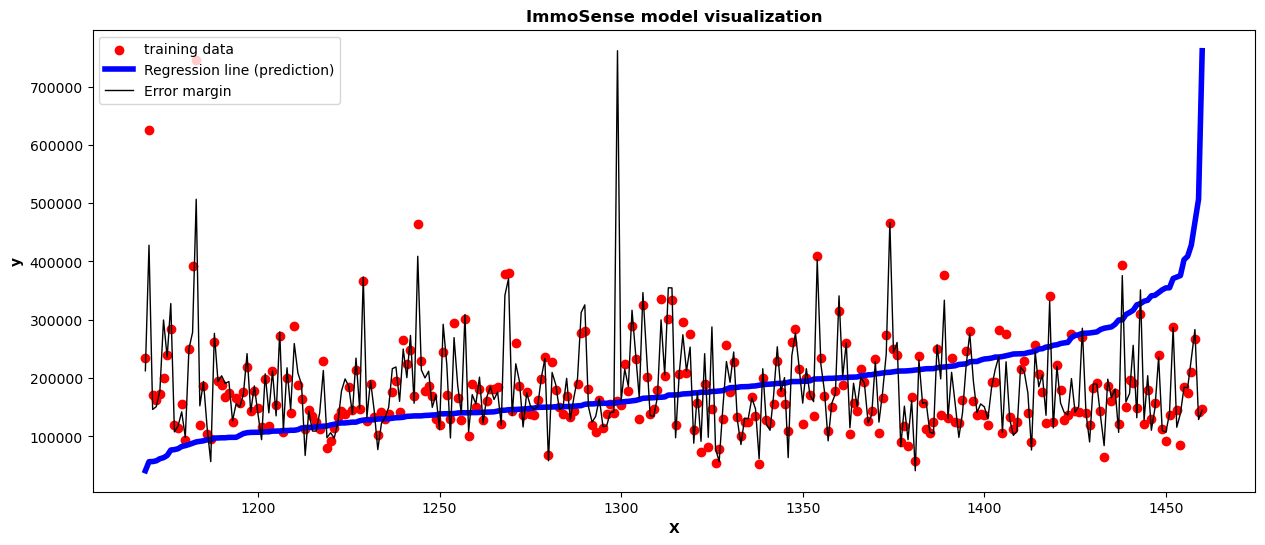

In [39]:
import matplotlib.pyplot as plt
pred = ImmoSense.predict(x_test)
plt.figure(figsize=(15, 6))
plt.scatter(x_test.index, y_test, color='red', label="training data")
plt.plot(x_test.index, sorted(pred), color='blue', linewidth=4, label="Regression line (prediction)")
plt.plot(x_test.index, pred, color='#000000', linewidth=1, label="Error margin")
plt.xlabel("X",fontdict={"weight": 1000})
plt.ylabel("y", fontdict={"weight": 1000})
plt.title("ImmoSense model visualization", fontdict={"weight": 1000})
plt.legend()
plt.show()

the plot above shows how the model learns. the `red dots` represent real data used for training. The `blue line` represents the prediction.
The fluctuation highlights the model's error *(over prediction/ under prediction)*. Overall, We have a good fluctuation. We assume that `ImmoSense is well trained`.

* Let's peek at **feature's weigh**. This study will show us how each chosen feature **impacts** in the **model's precision**.

In [23]:
feat_imp = pd.DataFrame({
    "Features": ImmoSense.feature_names_in_,
    "Coef":np.abs(ImmoSense.coef_)
})

data_categories = { #? dummies features used for model training
    "General features":['OverallCond', 'OverallQual','YearBuilt', 'YearRemodAdd' ],
    
    "Surfaces":["GrLivArea", "TotalBsmtSF", "LotArea"],
    
    "Garage": ['GarageFinish_Empty','GarageFinish_Fin', 'GarageFinish_RFn', 
                'GarageFinish_Unf', 'GarageType_2Types', 'GarageType_Attchd',
                'GarageType_Basment','GarageType_BuiltIn', 'GarageType_CarPort', 
                'GarageType_Detchd','GarageType_Empty'],
    
    "Rooms and bathrooms": ['FullBath','HalfBath','BedroomAbvGr', 'KitchenAbvGr'],
    
    "Quality": ['KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA',
                'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po',
                'ExterCond_TA', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd',
                'ExterQual_TA', 'BsmtCond_Empty', 'BsmtCond_Fa',
                'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA',
                'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd',
                'HeatingQC_Po', 'HeatingQC_TA'],
    
    "Location": ['Neighborhood_Blueste', 'Neighborhood_BrDale',
                'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
                'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
                'Neighborhood_Edwards', 'Neighborhood_Gilbert',
                'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
                'Neighborhood_Mitchel', 'Neighborhood_NAmes',
                'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
                'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
                'Neighborhood_OldTown', 'Neighborhood_SWISU',
                'Neighborhood_Sawyer', 'Neighborhood_SawyerW',
                'Neighborhood_Somerst', 'Neighborhood_StoneBr',
                'Neighborhood_Timber', 'Neighborhood_Veenker',
                'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM'
                ],
    
    "Additional feature value": ['Fireplaces', 'FireplaceQu_Empty',
                                'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd',
                                'FireplaceQu_Po', 'FireplaceQu_TA', 'WoodDeckSF',
                                'OpenPorchSF','Foundation_BrkTil','Foundation_CBlock',
                                'Foundation_PConc', 'Foundation_Slab','Foundation_Stone', 
                                'Foundation_Wood', 'CentralAir_N', 'CentralAir_Y'
                                ],
    
    "Sales variable": ['SaleCondition_Abnorml', 'SaleCondition_AdjLand',
                        'SaleCondition_Alloca', 'SaleCondition_Family',
                        'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleType_COD',
                        'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
                        'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
                        'MiscFeature_Empty', 'MiscFeature_Gar2', 'MiscFeature_Othr',
                        'MiscFeature_Shed', 'MiscFeature_TenC'],
    
    "Created features":['Exterior_AsbShng', 'Exterior_AsphShn',
                        'Exterior_Brk Cmn', 'Exterior_BrkFace', 'Exterior_CBlock',
                        'Exterior_CmentBd', 'Exterior_HdBoard', 'Exterior_ImStucc',
                        'Exterior_MetalSd', 'Exterior_Other', 'Exterior_Plywood',
                        'Exterior_Stone', 'Exterior_Stucco', 'Exterior_VinylSd',
                        'Exterior_Wd Sdng', 'Exterior_Wd Shng', 'Condition_Artery', 
                        'Condition_Feedr','Condition_Norm', 'Condition_PosA', 
                        'Condition_PosN','Condition_RRAe', 'Condition_RRAn', 
                        'Condition_RRNn']
}
coef_sum_tab = []

for categories_tab in data_categories.values():
    coef_sum_tab.append(
        feat_imp[feat_imp["Features"].isin(categories_tab)]["Coef"].sum()
    )
    
features_weigh = pd.DataFrame({"Weigh": np.int64(np.round(coef_sum_tab))}, index=data_categories.keys())
features_weigh.sort_values(ascending=True, inplace=True, by="Weigh")
features_weigh.style.background_gradient(cmap="coolwarm").format('{}$')

,Weigh
Surfaces,88$
General features,14970$
Rooms and bathrooms,30840$
Garage,66511$
Additional feature value,73303$
Sales variable,165330$
Quality,169704$
Location,262327$
Created features,307113$


Each coefficient represents the sample's increase effect (or decrease for negeative coefficients) on the target (SalePrice).  

In our case if we take the `Rooms and bathrooms` category, we can say say that , in general, if each supplementary room or bathroom increases the house's price by **30,840$**. Same for the other categories.  

What makes the features weigh study more relevant is that we notice how the features we created influences the sales price. In fact, the more material the house is built with our the better the condition is, the more sales price increases by **307,113$**

## <span style="background:rgba(136, 134, 10, 0.49); border-radius: 15px; padding: 2px 15px; text_shadow: 2px 2px 5px black"> **V. Final prediction**</span>
let's predict prices with the test_set file and store it in `data/submission.csv`

In [24]:
df_test.ffill(inplace=True) # handling some none relevant missing values
dummy_test = pd.get_dummies(df_test)
dummy_test = dummy_test.reindex(columns=dummy.columns, fill_value=0)
prices = ImmoSense.predict(dummy_test)
pd.DataFrame({"SalePrice": np.int64(prices)}, index=dummy_test.index).to_csv("../data/submission.csv",sep=",",header=True)
print(Fore.GREEN+"Submission file generated successfully !"+Style.BRIGHT+Style.RESET_ALL)

Submission file generated successfully !
